In [217]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})
import pickle
# from matplotlib.colors import LogNorm

In [207]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [208]:
!ls -l /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/

total 40628155
-rw-rw-r--+ 1 mabi3848 hpc-users  120392345 Jul 11 15:18 apo_conc_gly_50_2_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users      23079 Jun 28 14:11 background_0003.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1161373434 Jul 11 15:35 ferritin_conc100_gly_50_1_0002.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  703980477 Jul 11 15:39 ferritin_conc100_gly_50_1_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2330393309 Jul 11 15:54 ferritin_conc100_gly_50_1_0009.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1144299172 Jul 11 15:43 ferritin_conc100_gly_50_1_0010.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2461504414 Jul 11 16:12 ferritin_conc100_gly_50_1_0012.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2539875762 Jul  5 17:15 ferritin_conc100_gly_50_1_0013.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1604681690 Jul  5 17:06 ferritin_conc100_gly_50_1_0014.h5
-rw-rw-r--+ 1 mabi3848 hpc-users      86040 Jul  7 12:48 ferritin_conc120_gly_50_1_0002.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1234676974 Jul  7 13:07 ferritin_conc120_gly_50_1_0004.h5
-rw-rw-

In [242]:
# fluxes 220K: 4 full beam, 5 45%, 6 22.5%
# runs = ['ferritin_conc_gly_50_5_0004', 'ferritin_conc_gly_50_6_0005', 'ferritin_conc_gly_50_6_0006']
# fluxes 220K: 4 full beam, 5 45%, 6 22.5%

# c1 50-75 mg/ml before adding gly 220K
runname = ['ferritin_conc_gly_50_5']
datasetnumbers = [4,5,6]

# # c1 240 K
# runnames = ['ferritin_conc_gly_50_5', 'ferritin_conc_gly_50_6']
# datasetnumbers = [3,3]

# c2 80-120 mg/ml before adding gly 270 K
# runname = ['ferritin_conc100_gly_50_1']
# datasetnumbers = [13,14]

# c3 140-180 mg/ml before adding gly 240 K
# runname = ['ferritin_conc120_gly_50_2']
# datasetnumbers = [2,3,4,5]

if len(runname) == 1:
    runnames = runname*len(datasetnumbers)
runnames

['ferritin_conc_gly_50_5', 'ferritin_conc_gly_50_5', 'ferritin_conc_gly_50_5']

In [243]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0004
Temperature, K       220.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0005.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0005
Temperature, K       220.0
transmission (%)     45
Absorbers 80um       1.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, 45% beam
Exposure time (s)    0.0004
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0006.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0006
Temper

# Plot g2s

In [244]:
def exponential(x, beta, tau):
    return np.abs(beta) * np.exp( -2*x/(np.abs(tau)) )

def exponential_kww(x, beta, tau, kww):
    return np.abs(beta) * np.exp( -2*(x/(np.abs(tau)))**kww )

def linear(x, m):
    return m*x

In [245]:
rep = 0
filename = h5dir + f'{runnames[0]}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')


g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')


print(np.shape(g2s))

(3, 12, 80)


In [246]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')
beta_vs_q

array([0.15964507, 0.15949404, 0.15918963, 0.1587956 , 0.15834509,
       0.1576657 , 0.15686018, 0.15597819, 0.15482857, 0.15376757,
       0.15292362, 0.15141127])

### With kww=1

In [247]:
eta_50 = eta_50v_gly()
eta_60 = eta_60v_gly()

	 100%  5151.688619851538 91.3899272450905
	 45%  4381.015571064709 73.2897139927273
	 ~22.5%  4355.2165695920285 76.69644155248034


functions/fitting_tools.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DiffC.append(new_row, ignore_index=True)
functions/fitting_tools.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DiffC.append(new_row, ignore_index=True)
functions/fitting_tools.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DiffC.append(new_row, ignore_index=True)


Text(0.5, 0, 'Transmission (%)')

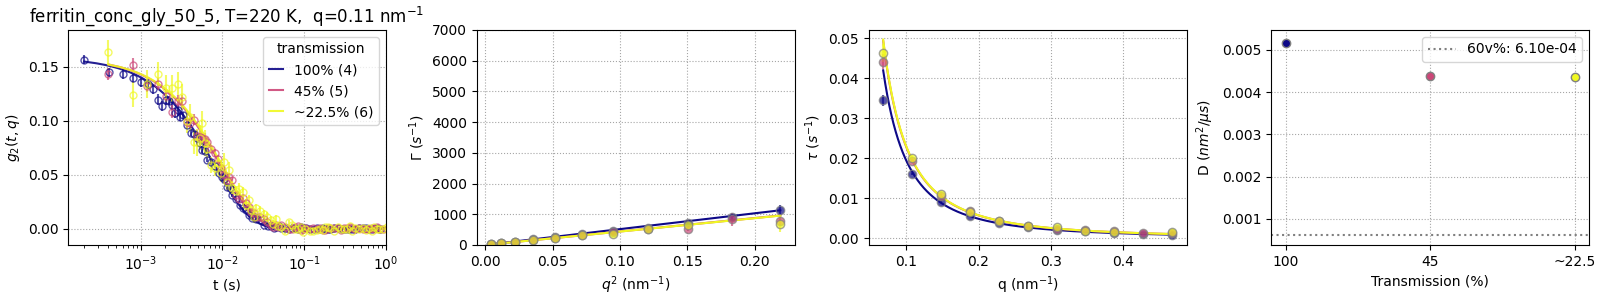

In [249]:
f, (a1,a3,a4,a5) = plt.subplots(1,4,figsize=(16,3), constrained_layout=True)
col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))

qv_sel = 2
tol = 1e-3
qmin, qmax, qstep = 1, len(qv), 1

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qmin, qmax, qstep):
        base = np.average(g2s[i,q,-15:])
        # popt,xc,curve,perr = fit(exponential, delay, g2s[i,q,:]-base, p0=[beta_vs_q[q],5e-3], bounds=[(beta_vs_q[q]-tol,0),(beta_vs_q[q]+tol,np.infty)])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:],  p0=[beta_vs_q[i],5e-3], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            # a1.plot(delays[i,:], g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:],c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{Tr[i]}% ({datasetnumbers[i]})')
    
    qs = qv[qmin:qmax:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0)
    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], p0=[5e4], sigma=dtaus[cond]/(taus[cond]**2))#,bounds=[(1e4), (1e5)] )#s)
    print("\t", f'{Tr[i]}% ', popt[0], perr[0])

    # update diffusion coefficient table
    # update_D_coeff(T=int(T[i][:-2]), Tr=f'{Tr[i]}%', D=popt[0]*1e-6, dD=perr[0]*1e-6, c='c3')

    a3.plot(xc, curve, c=col[i], label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')
    a4.plot(np.sqrt(xc), 1/curve, c=col[i], label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', alpha=0.7, mec='gray')
    a4.errorbar(qs[cond], taus[cond], dtaus[cond],c=col[i], ls='', marker='o', alpha=0.7, mec='gray')
    a5.errorbar(Tr[i], popt[0]*1e-6, perr[0]*1e-6, ls='', marker='o', c=col[i], mec='gray')

D1 = D_coeff(T=int(T[i][:-2]), eta=eta_50[int(T[i][:-2])])
D2 = D_coeff(T=int(T[i][:-2]), eta=eta_60[int(T[i][:-2])])
# a5.axhline(y=D1, ls='--', c='gray', label=f'50v%: {D1:.2e}')
a5.axhline(y=D2, ls=':', c='gray', label=f'60v%: {D2:.2e}')

a1.set_title(f"{runname}, T={T[0][:-2]} K,  q={qv[qv_sel]:.2f} nm$^{{-1}}$")
a1.legend(title=r'transmission', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_xscale('log')
a1.set_xlim(None, 1)
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a3.set_xlabel(r'$q^2$ (nm$^{-1}$)')
a3.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a3.set_ylim(0,7e3)
a4.set_xlabel(r'q (nm$^{-1}$)')
a4.set_ylabel(r'$\tau$ ($s^{-1}$)')
a5.set_ylabel(r'D (${nm}^{{2}}$/${\mu s}$)')
a5.legend(fontsize=10)
a5.set_xlabel(r'Transmission (%)')

In [250]:
# # load elog as pd dataframe
DiffC = pd.read_pickle("../03-source/diffusion_coefficient")
DiffC

,temperature,transmission,D,dD,c
0,240,45%,0.044803,0.000973,c1
1,240,100%,0.058330,0.002202,c1
2,220,100%,0.005152,0.000091,c1
3,220,45%,0.004381,0.000073,c1
4,220,~22.5%,0.004355,0.000077,c1


In [237]:
# keys = ['temperature', 'transmission', 'D', 'dD', 'c']
# df = pd.DataFrame(columns=keys)
# df.to_pickle("../03-source/diffusion_coefficient")
# df = pd.read_pickle("../03-source/diffusion_coefficient")
# df

,temperature,transmission,D,dD,c


In [204]:
# new_row = {'temperature': 200, 'transmission': 'test', 'D': 0.1, 'dD': 0.01}
# DiffC2 = DiffC.append(new_row, ignore_index=True)
# DiffC2.to_pickle("../03-source/diffusion_coefficient")
# DiffC3 = pd.read_pickle("../03-source/diffusion_coefficient")
# DiffC3

/tmp/ipykernel_3604/1330408370.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DiffC2 = DiffC.append(new_row, ignore_index=True)


,temperature,transmission,D,dD
0,200,test,0.1,0.01


In [ ]:
# def update_D_coeff(T, Tr, D, dD):
#     DiffC = pd.read_pickle("../03-source/diffusion_coefficient")
#     new_row = {'temperature': T, 'transmission': Tr, 'D': D, 'dD': dD}
#     DiffC2 = DiffC.concat(new_row, ignore_index=True)
#     DiffC2.to_pickle("../03-source/diffusion_coefficient")

In [132]:
# test = {'temperature': 200, 'transmission': '100%', 'D': 0.1, 'dD': 0.01}
# dic_DiffC2 = dic_DiffC.append(test, ignore_index=True)
# dic_DiffC2

In [125]:
# dic_DiffC2.to_pickle("../03-source/diff_coeff")

### Free kww

(0.0, 2.0)

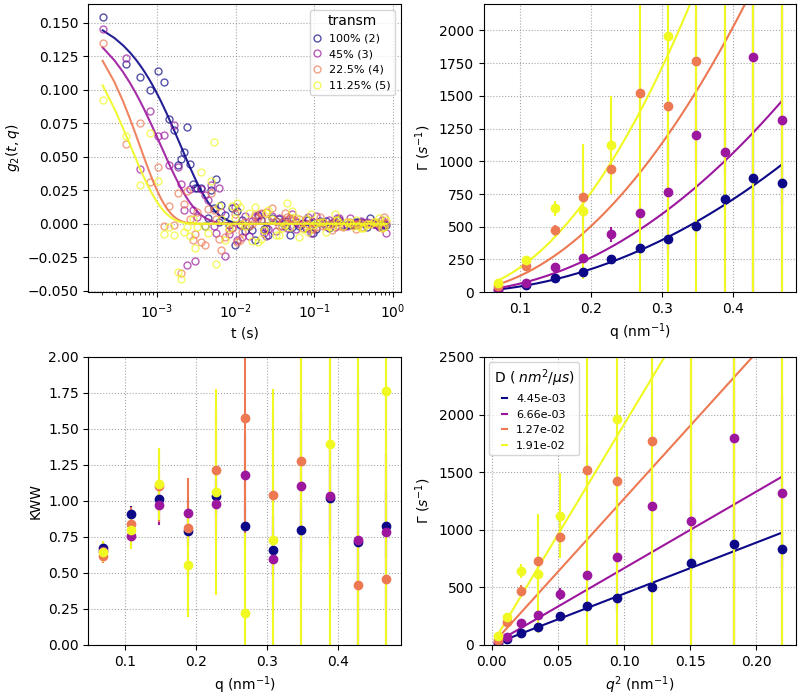

In [ ]:
f, ((a1,a2),(a3,a4)) = plt.subplots(2,2,figsize=(8,7), constrained_layout=True)
col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))

qv_sel = 5
tol = 1e-3
qv_min, qv_max = 1, len(qv)

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    kww, dkww = [], []
    
    for q in range(qv_min, qv_max):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential_kww,  delays[i,:], g2s[i,q,:]-base, p0=[beta_vs_q[q],5e-2,1.], 
                                 bounds=[(beta_vs_q[q]-tol,0,0),(beta_vs_q[q]+tol,np.infty,3)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        kww.append(popt[2])
        dkww.append(perr[2])
        
        if q==qv_sel:
            a1.plot( delays[i,:], g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7, label=f'{Tr[i]}% ({datasetnumbers[i]})')
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9)#, label=f'{qv[q]:.2f}')
        
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    kww, dkww = np.asarray(kww), np.asarray(dkww)

    popt,xc,curve,perr = fit(linear, qv[qv_min:qv_max]**2, 1/taus, sigma=dtaus/(taus**2), p0=[5e3])

    a2.plot(np.sqrt(xc), curve, c=col[i], label=f'{popt[0]*1e-6:.2e}')
    a2.errorbar(qv[qv_min:qv_max], 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    a4.plot(xc, curve, c=col[i], label=f'{popt[0]*1e-6:.2e}')
    a4.errorbar( qv[qv_min:qv_max]**2, 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    a3.errorbar(qv[qv_min:qv_max], kww, dkww, c=col[i], ls='', marker='o', label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')

# f.sup_title(f"{runname}, T={T[:-2]}K")
a1.legend(title=r'transm', fontsize=8, bbox_to_anchor=[1,1], handlelength=.5)
a4.legend(title=r'D ( ${{nm}}^{{2}}$/${{\mu s}}$)', fontsize=8, handlelength=.5)
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a2.set_xlabel(r'q (nm$^{-1}$)')
a2.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a2.set_ylim(0,2200)
a4.set_xlabel(r'$q^2$ (nm$^{-1}$)')
a4.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a4.set_ylim(0,2500)
a3.set_xlabel(r'q (nm$^{-1}$)')
a3.set_ylabel('KWW')
a3.set_ylim(0,2)

# Scattering intensity

## Todo
- plot different fluxes

In [71]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber,runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iqs[i,:] = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    info = elog_selected_entries_dict(filename)
    t_exp.append(float(info['Exposure time (s)']))
    print(datasetnumber, t_exp[i], 's')

print(np.shape(Iqs), np.shape(qI))

3 0.0004 s
3 0.0002 s
(2, 1000) (1000,)


In [72]:
# water/glycerol
f = np.load("../03-source/backgrounds.npz")
f.files
Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
q_bkg = f['q']
t_exp_bkg = 1e-1

# apoferritin
f = np.load("../03-source/Iqs_apo_conc_gly_50_2_0006.npz")
f.files
Iq_apo = np.average(f['Iqs'],axis=0)
q_apo = f['q']
t_exp_apo = 5e-3

(0.2, 10.0)

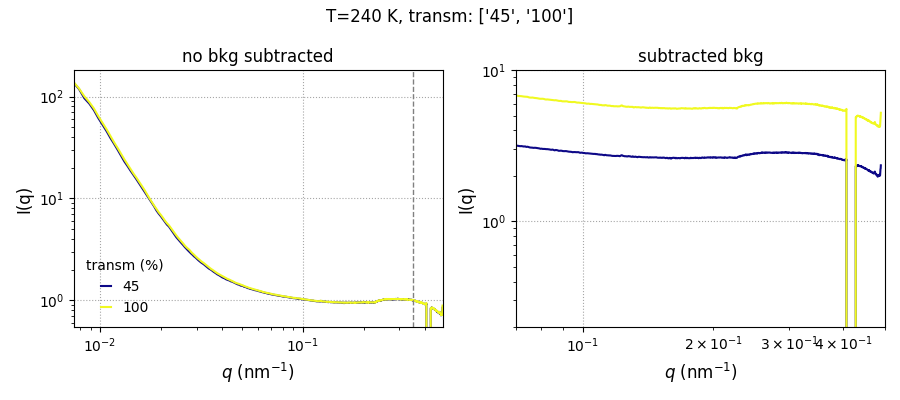

In [73]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))

q_index = 710
for i in range(len(datasetnumbers)):
    # a1.plot(qI, Iqs[i,:]*(1-float(Tr[i])/100), ls='-', c=col[i], label=f'{Tr[i]}')
    a1.plot(qI, Iqs[i,:]/Iqs[i,q_index], ls='-', c=col[i], label=f'{Tr[i]}')

    # y = Iqs[i,:]-Iq_bkg/t_exp_bkg*t_exp[i]# - Iq_bkg/Iq_bkg[6]*Iqs[i,6]
    y = Iqs[i,:] - Iq_bkg/Iq_bkg[q_index]*Iqs[i,q_index]
    a2.plot(qI, y, c=col[i], ls='-', label=f'{Tr[i]}')
    a2.plot(qI, Iqs[i,:]/t_exp[i], ls='-', c=col[i], label=f'{Tr[i]}')

# a1.plot(qI, Iq_bkg/Iq_bkg[q_index], ls='--', c='k')
f.suptitle(f'T={T[0][:-2]} K, transm: {Tr}')
a1.axvline(x=qI[q_index], ls='--', c='gray', lw=1)
a1.legend(title='transm (%)', handlelength=.7, frameon=False)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('I(q)', fontsize=12)
a1.set_xscale('log')
a1.set_yscale('log')
a1.set_xlim(qI[0],qI[-1])
# a1.set_xlim(9e-2,qI[-1])
# a1.set_ylim(7e-1,1.5e0)
a1.set_title('no bkg subtracted')
a2.set_title('subtracted bkg')
a2.set_ylabel('I(q)', fontsize=12)
a2.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a2.set_xscale('log')
a2.set_yscale('log')
a2.set_xlim(.07,.5)
a2.set_ylim(2e-1,1e1)